These tests are similar to the previous round, but I'm collecting data differently. The Sample type has been modified to be isbits (storing SVectors) and to more clearly record which warmstart cost is which. I'm also going to try to modify the loss function to operate directly on Samples so that I can just store those. This should make experimenting with things like learning `u` easier. 

In [9]:
using Revise

In [10]:
using MeshCatMechanisms
using MeshCat
using RigidBodyDynamics
using Flux
using ProgressMeter
using MLDataPattern
using JLD2
using Plots; gr()
using LCPSim
using LearningMPC
using LearningMPC.Models

In [11]:
using Blink

In [12]:
robot = BoxAtlas(add_contacts=false)
mvis = MechanismVisualizer(robot)
open(mvis, Window())

Blink.AtomShell.Window(1, Blink.AtomShell.Electron(Process(`/home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Blink/deps/atom/electron /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Blink/src/AtomShell/main.js port 8636`, ProcessRunning), TCPSocket(RawFD(68) active, 0 bytes waiting), Dict{String,Any}(Pair{String,Any}("callback", Blink.#1))), Blink.Page(2, WebSockets.WebSocket{TCPSocket}(TCPSocket(RawFD(73) active, 0 bytes waiting), true, CONNECTED::WebSockets.ReadyState = 1), Dict{String,Any}(Pair{String,Any}("webio", WebIO.#111),Pair{String,Any}("callback", Blink.#1)), Future(1, 1, 2, Nullable{Any}(true))))

In [13]:
params = MPCParams(robot)
lqrsol = LQRSolution(robot, params, false)
net, loss = LearningMPC.interval_net([22, 32, 32, 1]; regularization=1e-3)
optimizer = Flux.ADAM(Flux.params(net))

net_cost = LearningMPC.LearnedCost(lqrsol, net)

net_mpc_params = MPCParams(robot)
net_mpc_params.horizon = 1
net_mpc_controller = MPCController(robot, net_mpc_params, net_cost, [lqrsol]);

full_mpc_controller = MPCController(robot, params, lqrsol, [lqrsol, net_mpc_controller]);

lqr_mpc_controller = MPCController(robot, (p = MPCParams(robot); p.horizon=1; p), lqrsol, [lqrsol])

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


(::MPCController) (generic function with 1 method)

In [14]:
sample_sink = LearningMPC.MPCSampleSink(keep_nulls=false; lqrsol=lqrsol, 
    lqr_warmstart_index=1,
    learned_warmstart_index=2)

playback_sink = LearningMPC.PlaybackSink{Float64}(mvis)

full_mpc_controller.callback = LearningMPC.multiplex!(
    sample_sink,
    playback_sink
)

live_viewer = LearningMPC.live_viewer(mvis)

dagger_controller = LearningMPC.multiplex!(
    LearningMPC.dagger_controller(
        full_mpc_controller,
        net_mpc_controller),
    live_viewer
    )

collect_into! = let x_init = nominal_state(robot), x0 = MechanismState{Float64}(robot.mechanism), sink = sample_sink
    function (data::Vector{<:LearningMPC.Sample}, σv)
        empty!(sink)
#         copy!(x0, x_init)
#         set_velocity!(x0, findjoint(x0.mechanism, "floating_base"),
#             [σv * (2 * (rand() - 0.5)), 0.0, 0.0])
        LearningMPC.randomize!(x0, x_init, 0.0, σv)
        Δv = zeros(num_velocities(x0))
        Δv[1] = σv * (2 * rand() - 0.5)
        set_velocity!(x0, velocity(x0) .+ Δv)
        results = LCPSim.simulate(x0, 
            dagger_controller,
            robot.environment, params.Δt, 50, 
            params.lcp_solver;
            termination=x -> configuration(x)[3] > π/4 || configuration(x)[3] < -π/4);
        append!(data, sink.samples)
    end
end

(::#19) (generic function with 1 method)

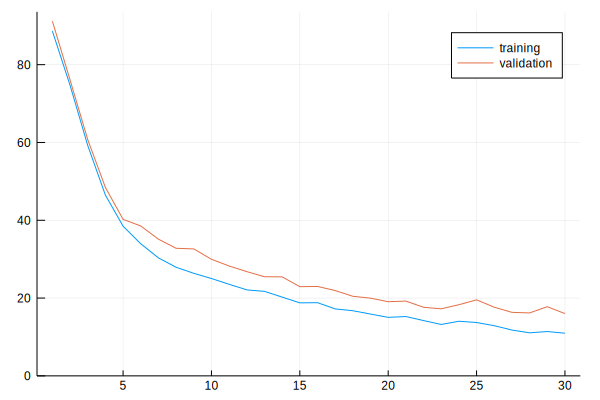

372.018865 seconds (1.07 G allocations: 125.818 GiB, 12.52% gc time)


Progress:   0%|                                         |  ETA: 1 days, 19:18:32

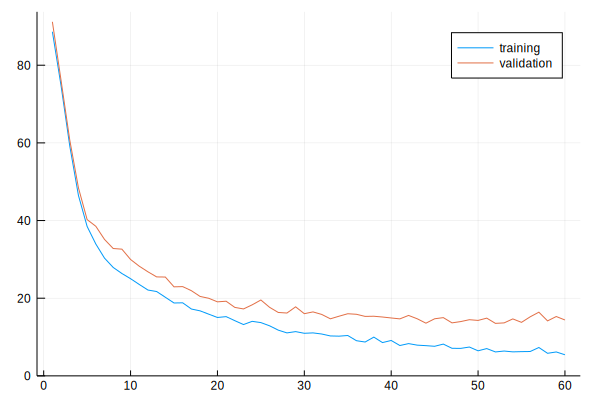

375.264017 seconds (1.08 G allocations: 126.111 GiB, 12.80% gc time)


Progress:   1%|                                         |  ETA: 1 days, 17:07:23

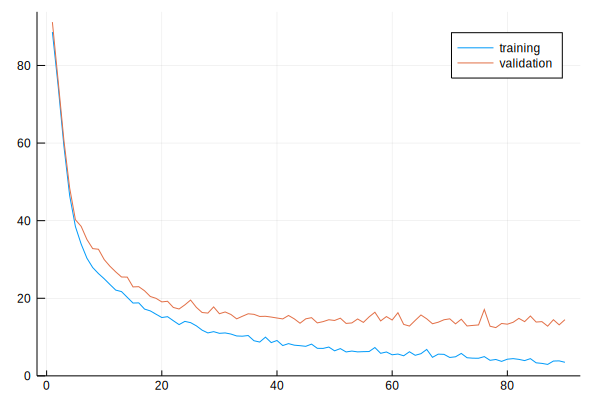

377.335694 seconds (1.08 G allocations: 126.732 GiB, 12.62% gc time)


Progress:   2%|█                                        |  ETA: 1 days, 17:31:55

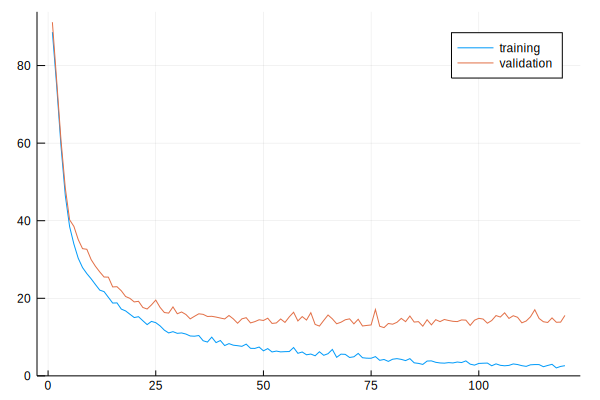

377.555037 seconds (1.08 G allocations: 126.956 GiB, 12.78% gc time)


Progress:   2%|█                                        |  ETA: 1 days, 14:12:12

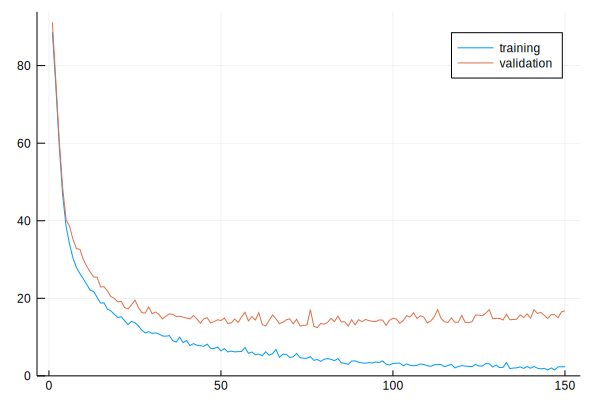

382.329914 seconds (1.09 G allocations: 127.488 GiB, 12.63% gc time)


Progress:   2%|█                                        |  ETA: 1 days, 14:21:25

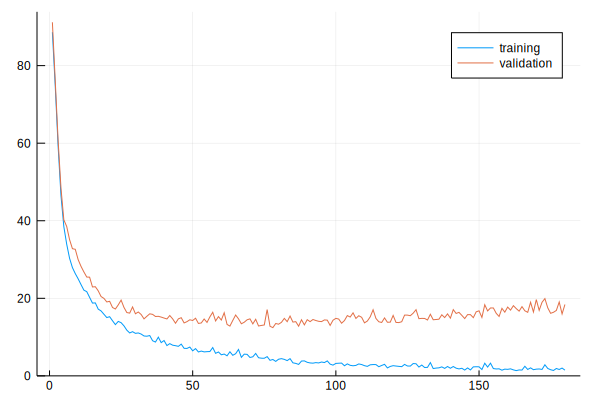

385.936052 seconds (1.09 G allocations: 127.791 GiB, 12.62% gc time)


Progress:   3%|█                                        |  ETA: 1 days, 14:26:43

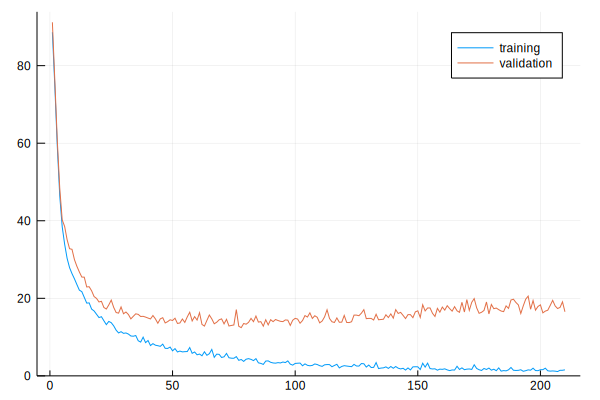

379.404239 seconds (1.09 G allocations: 128.378 GiB, 12.79% gc time)


Progress:   4%|█                                        |  ETA: 1 days, 14:52:40

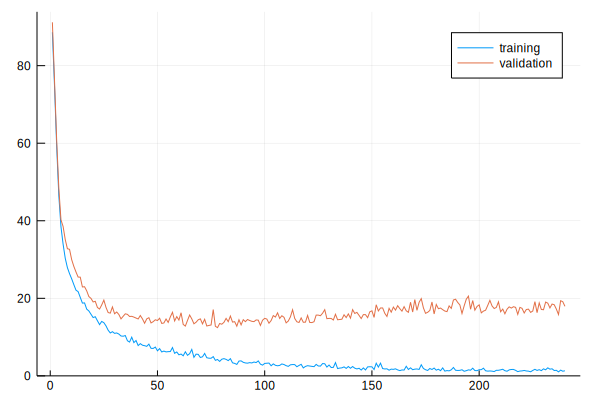

377.841612 seconds (1.10 G allocations: 128.874 GiB, 12.85% gc time)


Progress:   4%|██                                       |  ETA: 1 days, 14:26:00

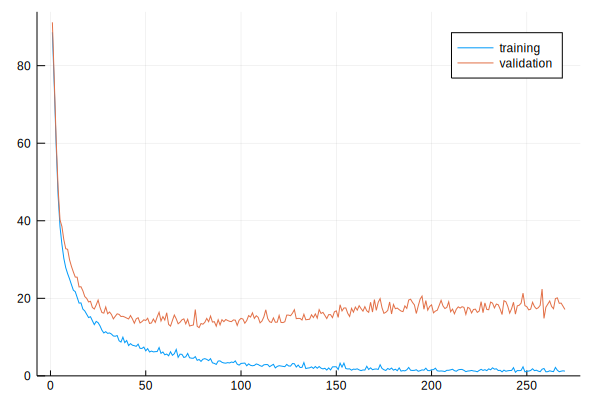

380.643859 seconds (1.11 G allocations: 129.917 GiB, 12.77% gc time)


Progress:   4%|██                                       |  ETA: 1 days, 16:51:16

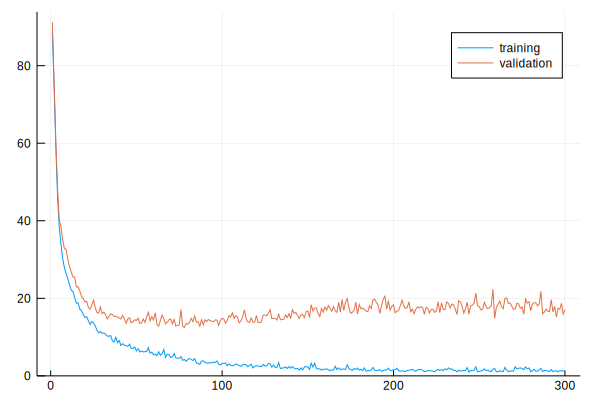

383.476155 seconds (1.11 G allocations: 130.523 GiB, 12.83% gc time)


Progress:   5%|██                                       |  ETA: 1 days, 16:37:11

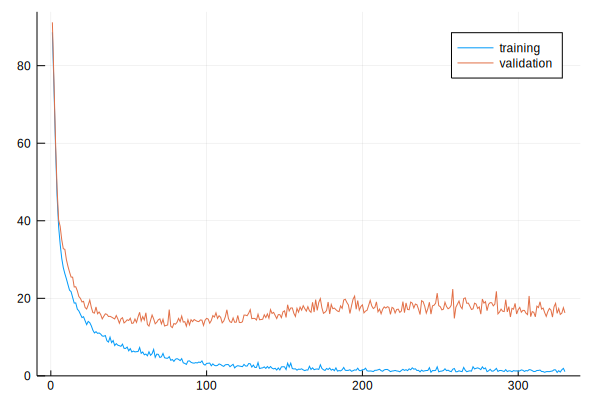

385.384139 seconds (1.12 G allocations: 130.831 GiB, 12.88% gc time)


Progress:   6%|██                                       |  ETA: 1 days, 15:29:22

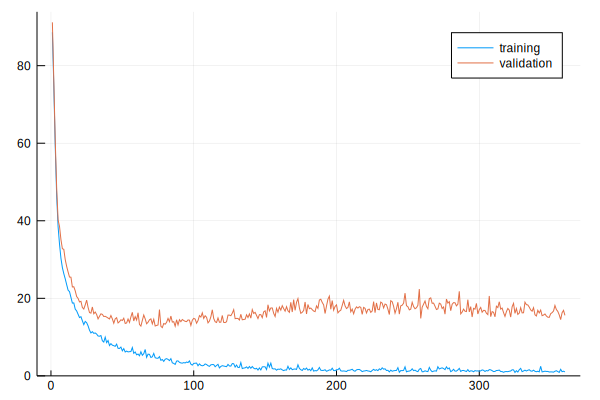

384.598580 seconds (1.12 G allocations: 131.379 GiB, 12.57% gc time)


Progress:   6%|██                                       |  ETA: 1 days, 15:10:42

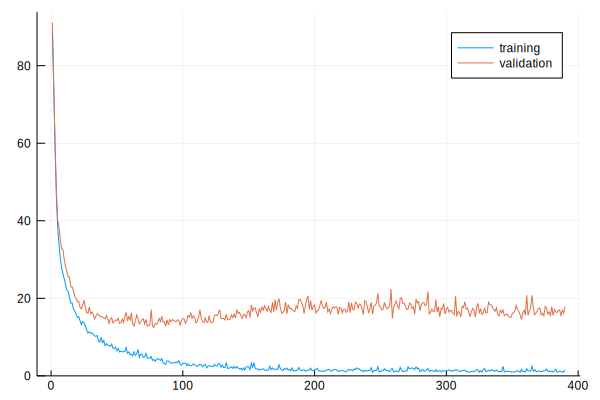

388.447175 seconds (1.12 G allocations: 131.735 GiB, 12.67% gc time)


Progress:   6%|███                                      |  ETA: 1 days, 14:59:10

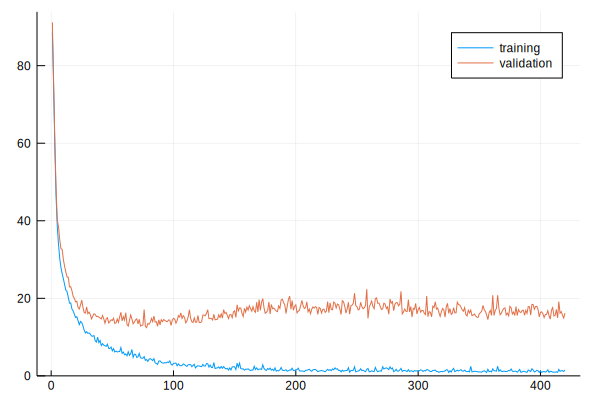

388.715333 seconds (1.13 G allocations: 131.985 GiB, 12.82% gc time)


Progress:   7%|███                                      |  ETA: 1 days, 14:40:49

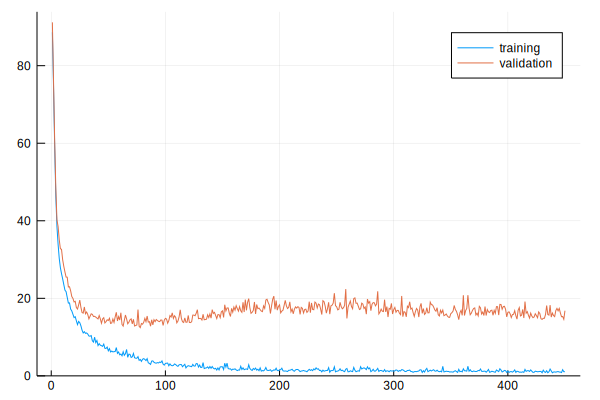

389.652857 seconds (1.13 G allocations: 132.706 GiB, 12.65% gc time)


Progress:   8%|███                                      |  ETA: 1 days, 15:17:46

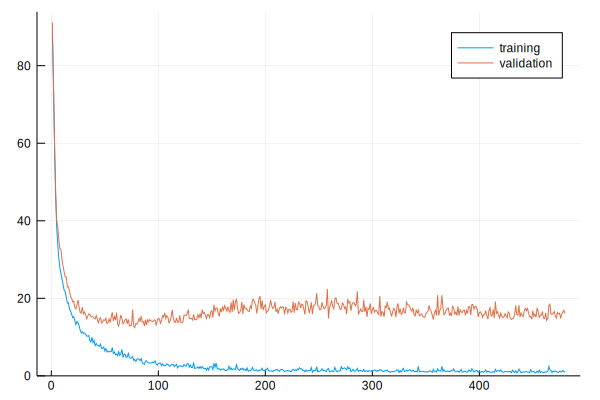

390.072063 seconds (1.14 G allocations: 133.382 GiB, 12.70% gc time)


Progress:   8%|███                                      |  ETA: 1 days, 15:44:37

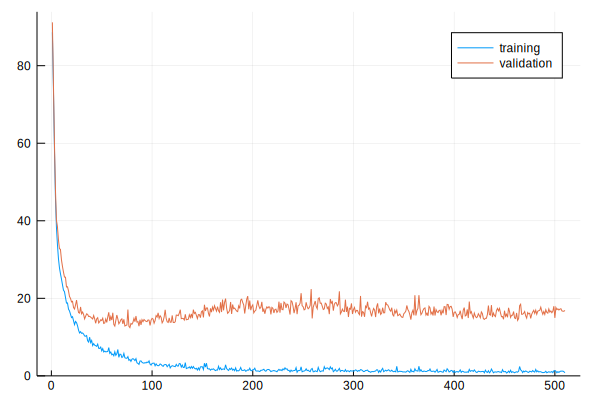

396.697667 seconds (1.15 G allocations: 134.274 GiB, 12.87% gc time)


Progress:   8%|███                                      |  ETA: 1 days, 16:00:36

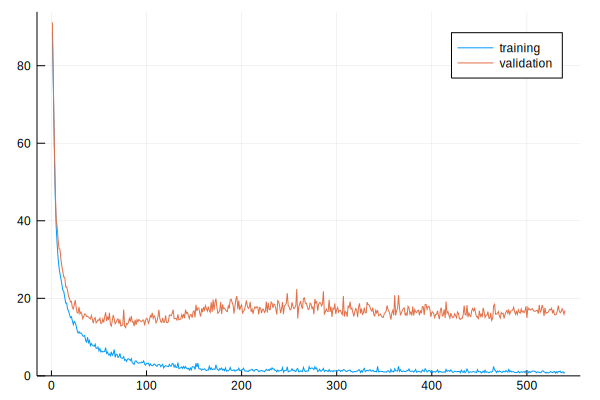

395.492102 seconds (1.15 G allocations: 135.324 GiB, 12.58% gc time)


Progress:   9%|████                                     |  ETA: 1 days, 16:53:09

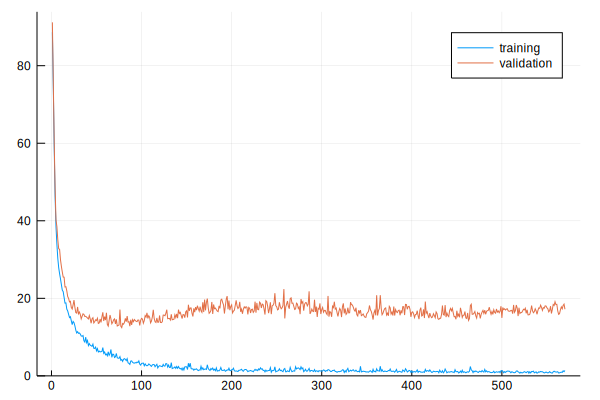

396.799940 seconds (1.16 G allocations: 135.868 GiB, 12.75% gc time)


Progress:  10%|████                                     |  ETA: 1 days, 16:30:05

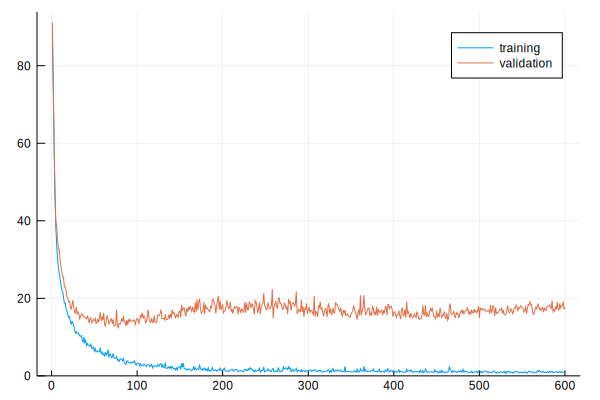

400.071065 seconds (1.17 G allocations: 136.633 GiB, 12.68% gc time)


Progress:  10%|████                                     |  ETA: 1 days, 16:23:11

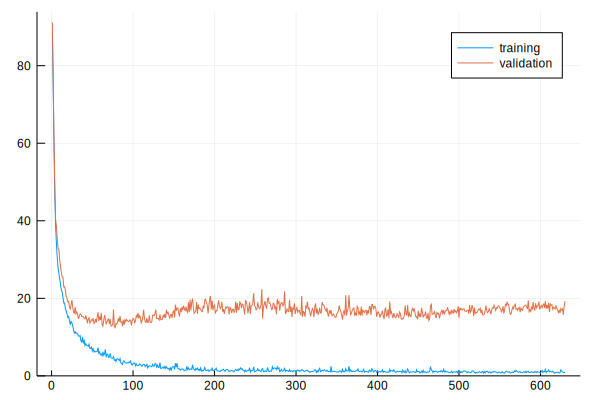

401.279008 seconds (1.17 G allocations: 136.759 GiB, 12.73% gc time)


Progress:  10%|████                                     |  ETA: 1 days, 15:25:48

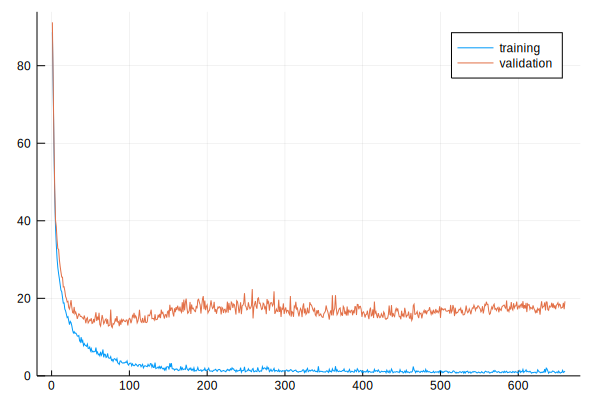

400.667015 seconds (1.17 G allocations: 137.268 GiB, 12.74% gc time)


Progress:  11%|█████                                    |  ETA: 1 days, 15:01:49

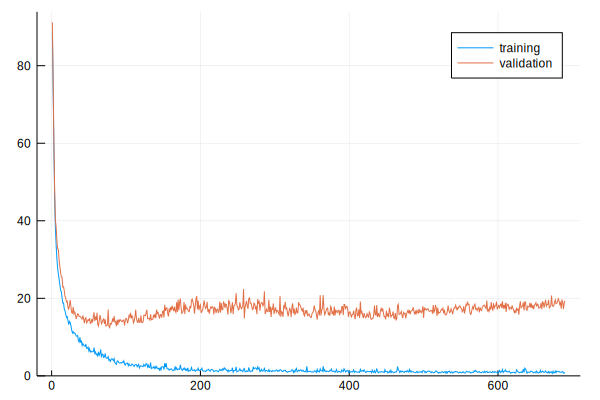

402.254014 seconds (1.17 G allocations: 137.553 GiB, 12.58% gc time)


Progress:  12%|█████                                    |  ETA: 1 days, 14:41:10

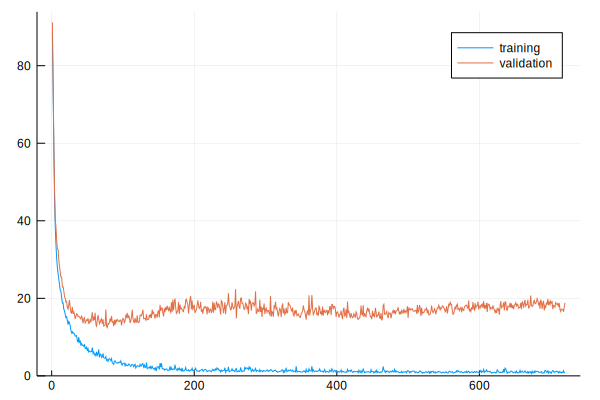

404.821238 seconds (1.18 G allocations: 138.602 GiB, 12.62% gc time)


Progress:  12%|█████                                    |  ETA: 1 days, 15:16:56

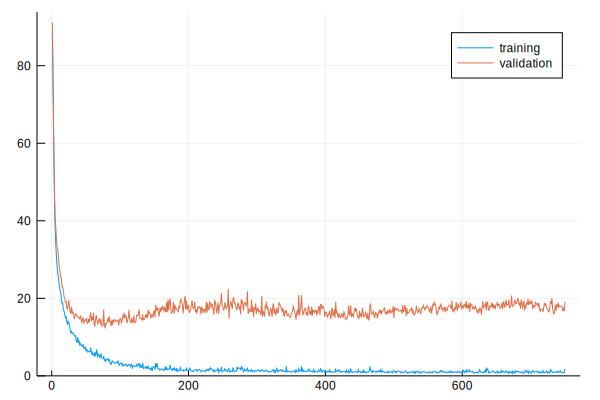

408.478718 seconds (1.19 G allocations: 139.314 GiB, 12.90% gc time)


Progress:  12%|█████                                    |  ETA: 1 days, 15:26:06

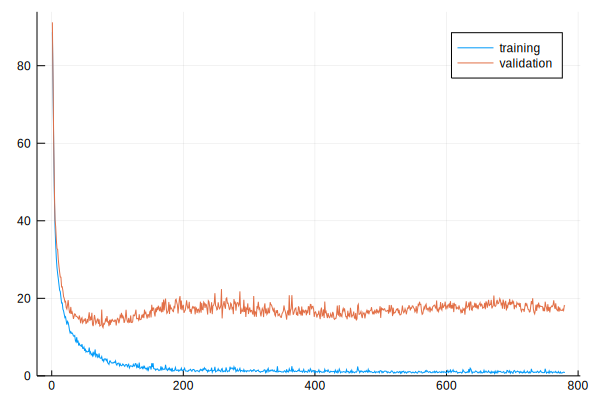

409.454040 seconds (1.19 G allocations: 139.973 GiB, 12.85% gc time)


Progress:  13%|█████                                    |  ETA: 1 days, 15:33:15

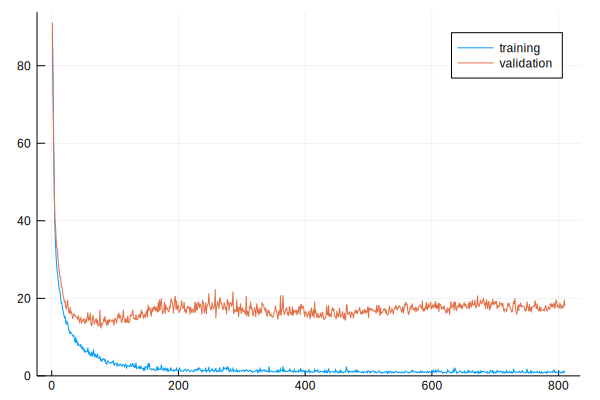

410.012215 seconds (1.20 G allocations: 140.231 GiB, 12.83% gc time)


Progress:  14%|██████                                   |  ETA: 1 days, 15:11:43

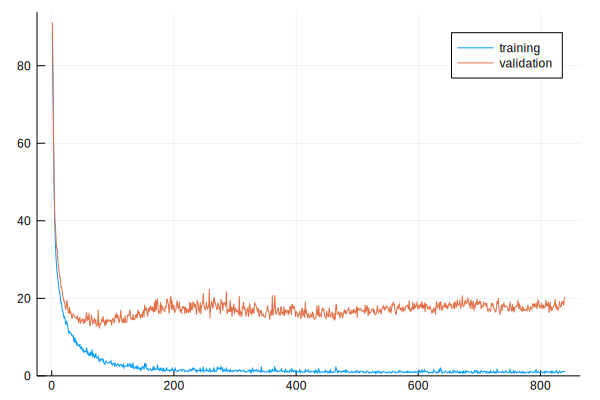

411.999715 seconds (1.20 G allocations: 140.780 GiB, 12.77% gc time)


Progress:  14%|██████                                   |  ETA: 1 days, 14:59:14

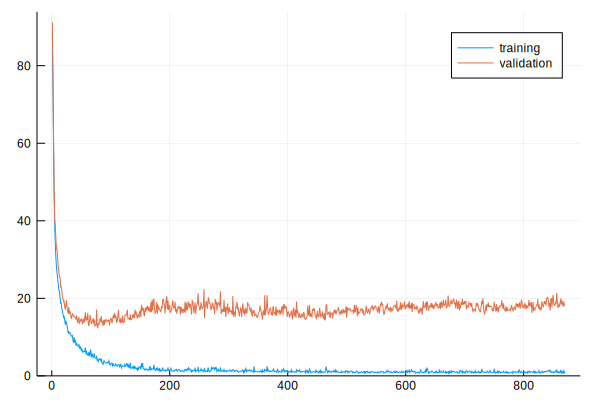

412.063245 seconds (1.20 G allocations: 141.065 GiB, 12.71% gc time)


Progress:  14%|██████                                   |  ETA: 1 days, 14:38:34

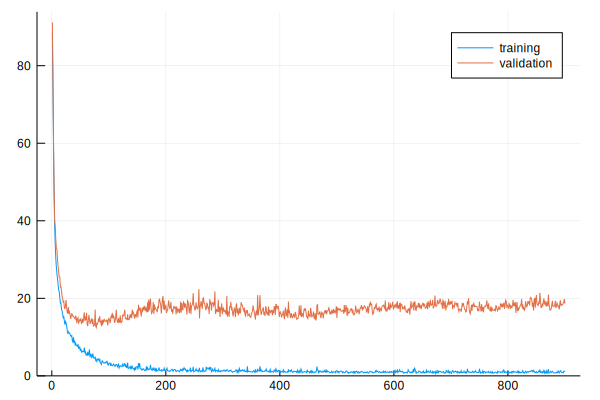

414.055062 seconds (1.21 G allocations: 141.526 GiB, 12.83% gc time)


Progress:  15%|██████                                   |  ETA: 1 days, 14:14:59

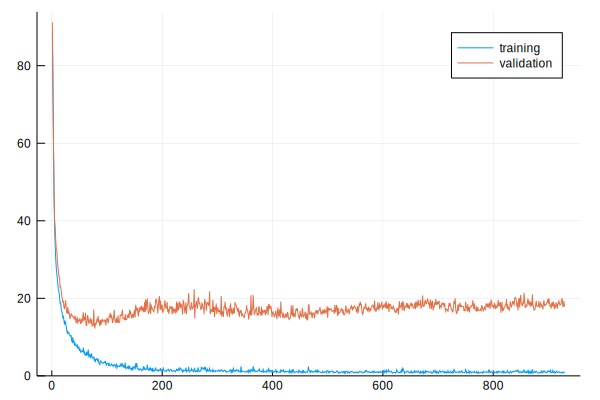

415.414245 seconds (1.21 G allocations: 141.774 GiB, 12.76% gc time)


Progress:  16%|██████                                   |  ETA: 1 days, 13:49:15

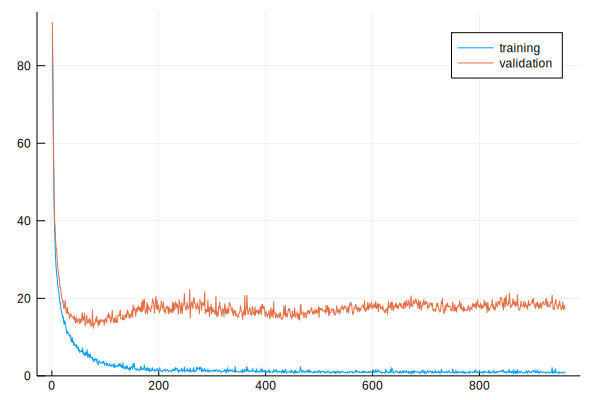

415.523485 seconds (1.21 G allocations: 142.450 GiB, 12.66% gc time)


Progress:  16%|███████                                  |  ETA: 1 days, 13:51:14

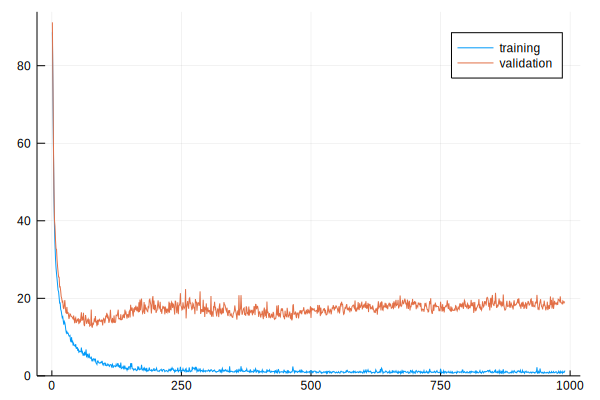

418.763899 seconds (1.22 G allocations: 143.035 GiB, 12.86% gc time)


Progress:  16%|███████                                  |  ETA: 1 days, 13:37:20

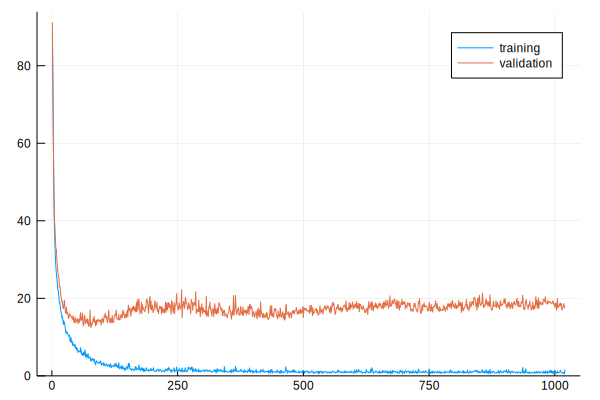

419.095019 seconds (1.22 G allocations: 143.250 GiB, 12.84% gc time)


Progress:  17%|███████                                  |  ETA: 1 days, 13:03:09

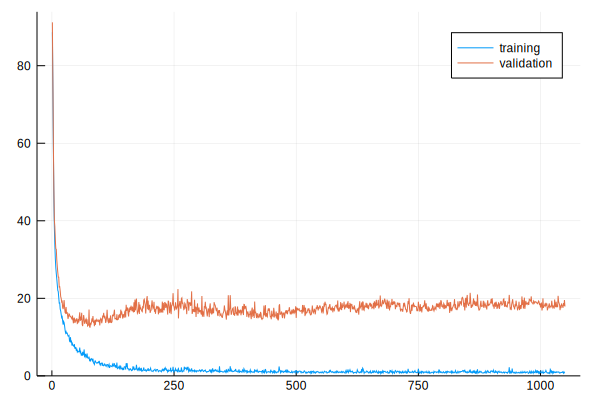

422.709526 seconds (1.23 G allocations: 143.808 GiB, 12.63% gc time)


Progress:  18%|███████                                  |  ETA: 1 days, 12:46:04

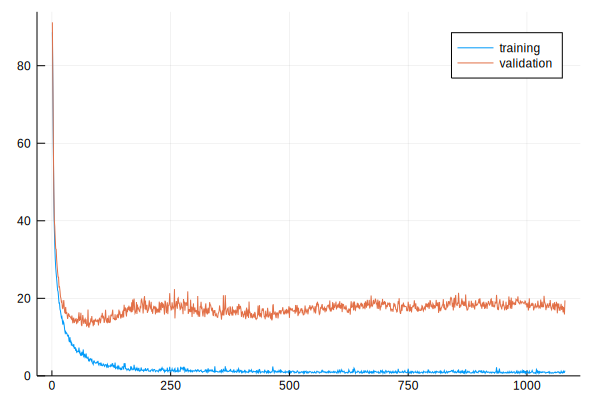

422.719000 seconds (1.23 G allocations: 144.102 GiB, 12.85% gc time)


Progress:  18%|███████                                  |  ETA: 1 days, 12:29:50

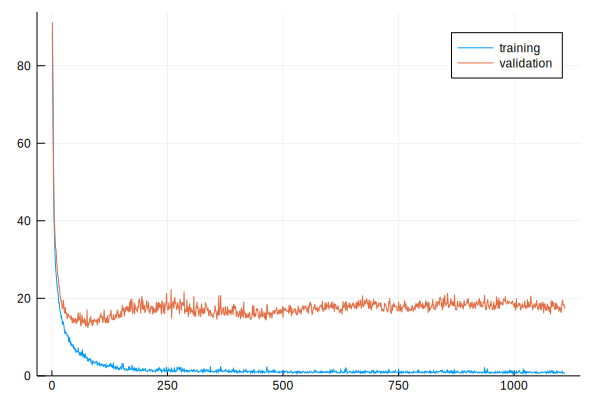

422.542714 seconds (1.23 G allocations: 144.343 GiB, 12.70% gc time)


Progress:  18%|████████                                 |  ETA: 1 days, 12:03:32

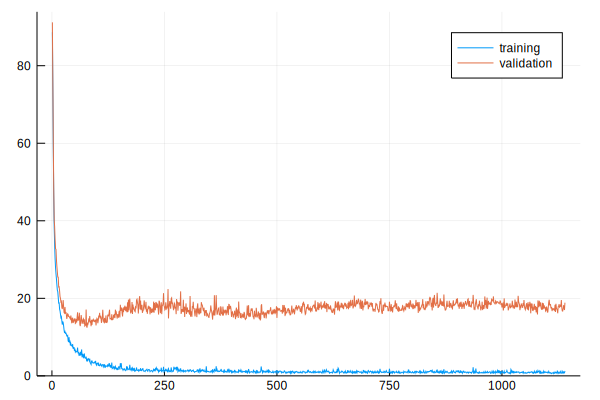

424.829233 seconds (1.24 G allocations: 144.908 GiB, 12.78% gc time)


Progress:  19%|████████                                 |  ETA: 1 days, 11:50:02

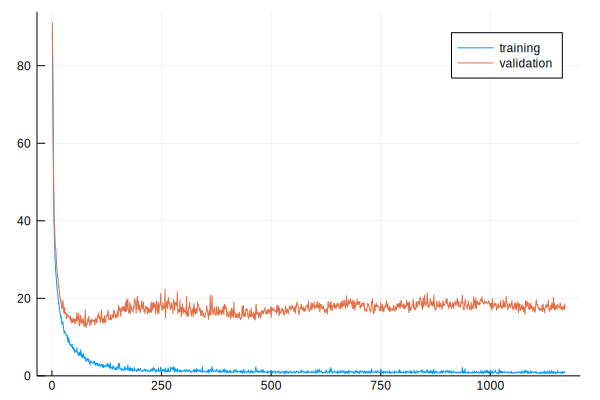

427.591358 seconds (1.24 G allocations: 145.801 GiB, 12.79% gc time)


Progress:  20%|████████                                 |  ETA: 1 days, 11:50:53

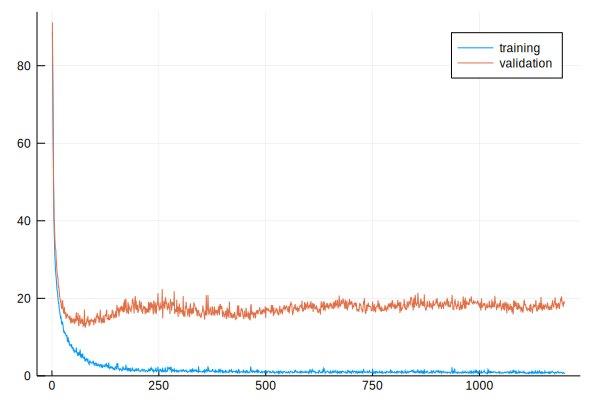

428.538762 seconds (1.25 G allocations: 146.403 GiB, 12.62% gc time)


Progress:  20%|████████                                 |  ETA: 1 days, 11:39:10

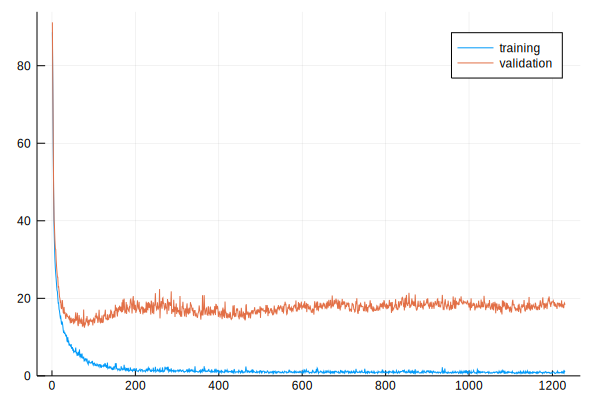

430.386932 seconds (1.25 G allocations: 147.124 GiB, 12.63% gc time)


Progress:  20%|████████                                 |  ETA: 1 days, 11:39:22

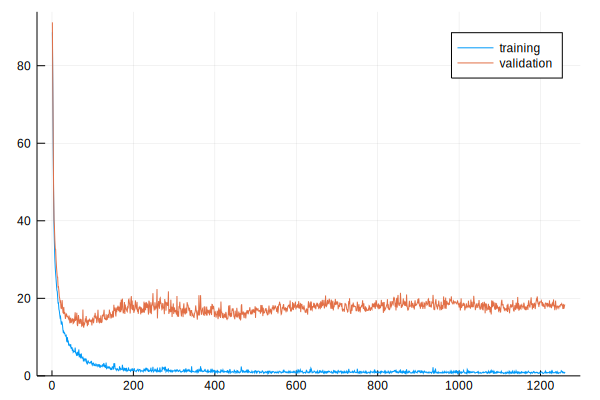

432.505724 seconds (1.26 G allocations: 147.818 GiB, 12.57% gc time)


Progress:  21%|█████████                                |  ETA: 1 days, 11:37:30

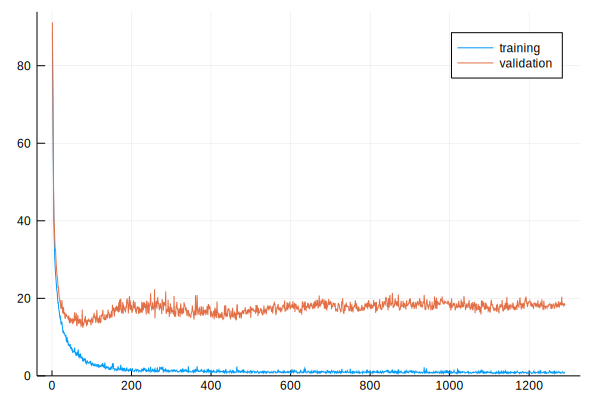

432.374919 seconds (1.26 G allocations: 148.296 GiB, 12.62% gc time)


Progress:  22%|█████████                                |  ETA: 1 days, 11:19:12

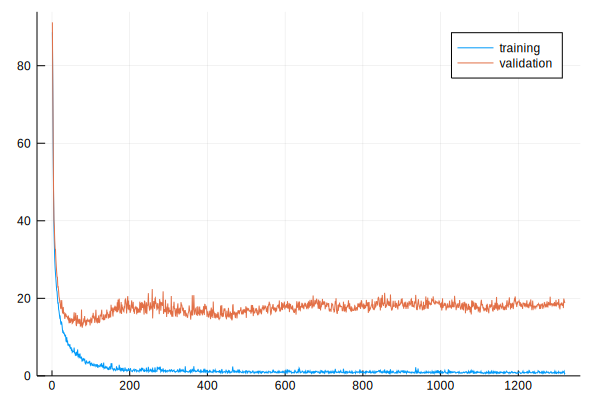

438.129483 seconds (1.27 G allocations: 148.815 GiB, 12.80% gc time)


Progress:  22%|█████████                                |  ETA: 1 days, 11:05:25

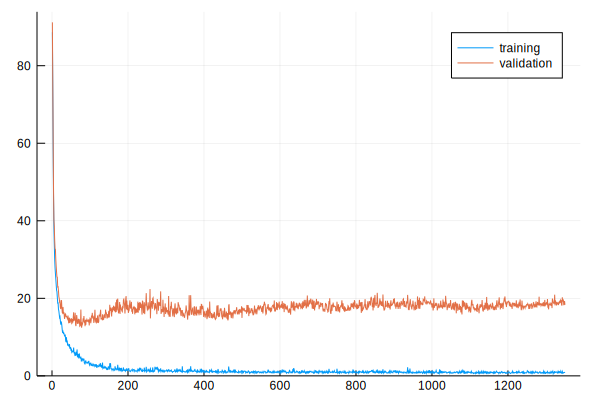

436.792938 seconds (1.27 G allocations: 149.314 GiB, 12.61% gc time)


Progress:  22%|█████████                                |  ETA: 1 days, 10:56:17

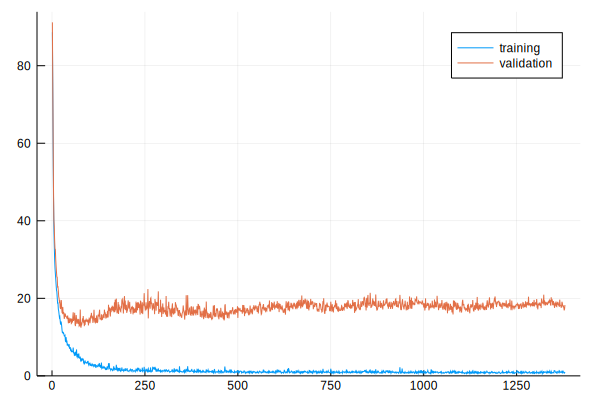

438.392638 seconds (1.28 G allocations: 149.695 GiB, 12.61% gc time)


Progress:  23%|█████████                                |  ETA: 1 days, 10:35:49

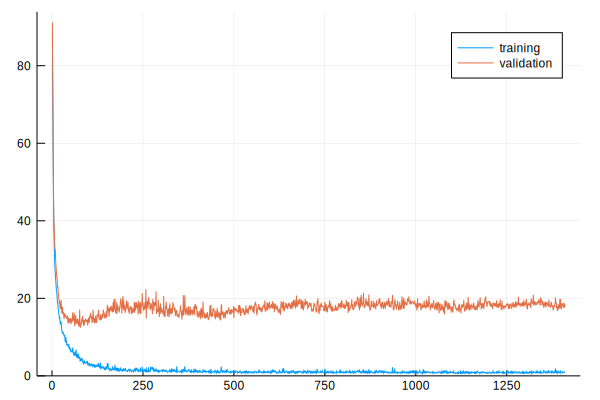

441.171257 seconds (1.28 G allocations: 150.203 GiB, 12.80% gc time)


Progress:  24%|██████████                               |  ETA: 1 days, 10:27:58

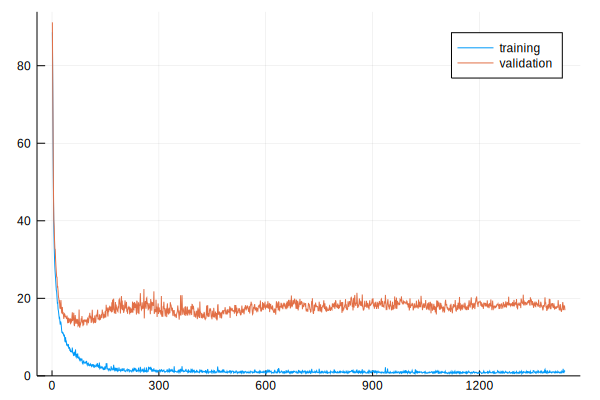

441.993901 seconds (1.29 G allocations: 150.870 GiB, 12.72% gc time)


Progress:  24%|██████████                               |  ETA: 1 days, 10:25:08

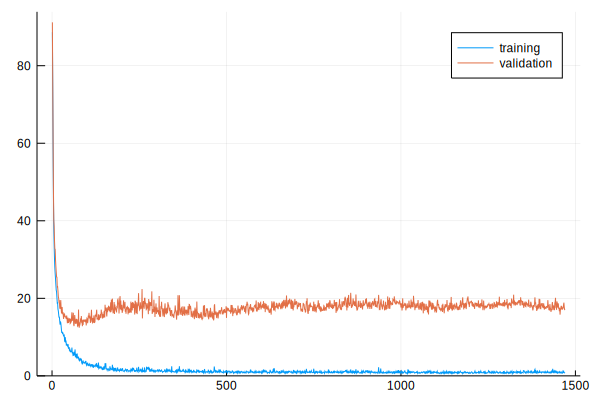

443.577894 seconds (1.29 G allocations: 151.546 GiB, 12.76% gc time)


Progress:  24%|██████████                               |  ETA: 1 days, 10:19:22

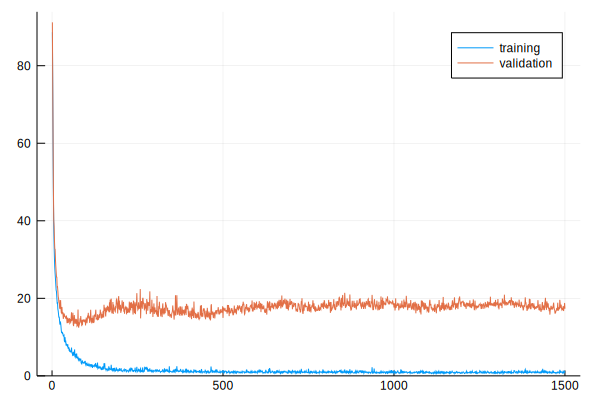

444.656444 seconds (1.30 G allocations: 152.034 GiB, 12.68% gc time)


Progress:  25%|██████████                               |  ETA: 1 days, 10:02:14

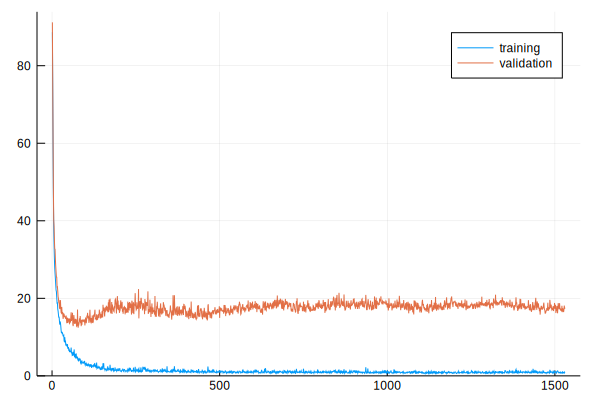

446.383575 seconds (1.30 G allocations: 152.527 GiB, 12.64% gc time)


Progress:  26%|██████████                               |  ETA: 1 days, 9:44:30

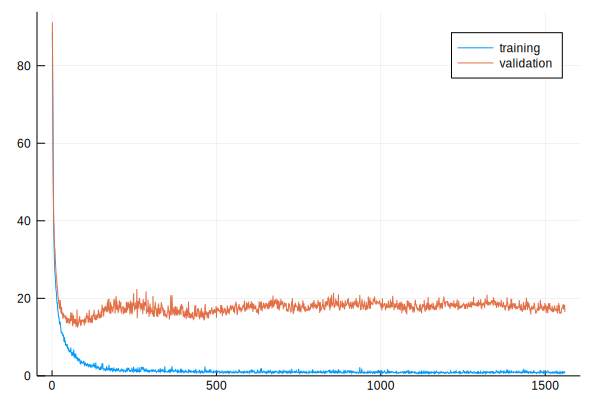

447.487882 seconds (1.30 G allocations: 152.706 GiB, 12.75% gc time)


Progress:  26%|███████████                              |  ETA: 1 days, 9:19:43

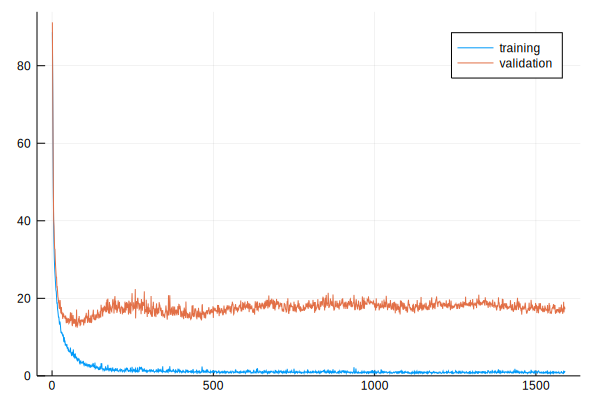

453.424201 seconds (1.31 G allocations: 153.617 GiB, 12.86% gc time)


Progress:  26%|███████████                              |  ETA: 1 days, 9:15:59

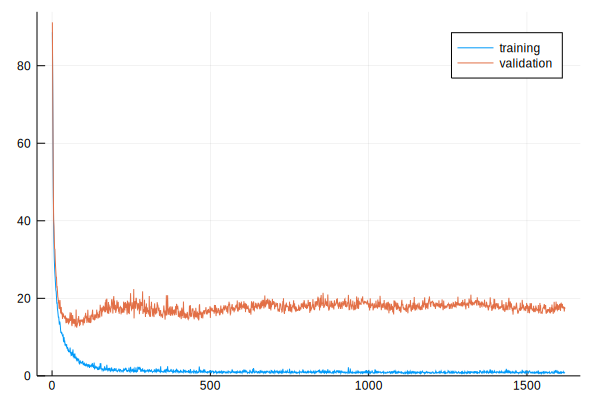

452.878768 seconds (1.32 G allocations: 154.391 GiB, 12.91% gc time)


Progress:  27%|███████████                              |  ETA: 1 days, 9:14:38

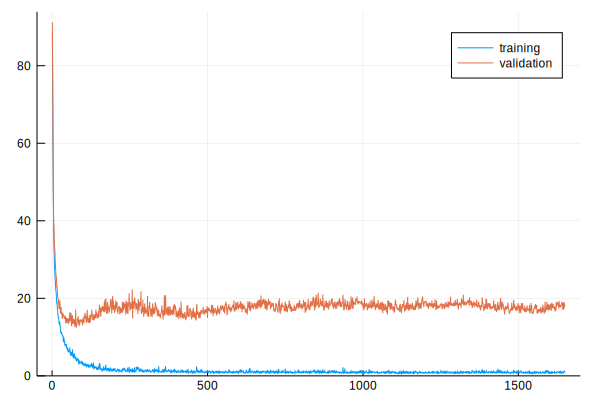

455.351709 seconds (1.32 G allocations: 154.893 GiB, 12.95% gc time)


Progress:  28%|███████████                              |  ETA: 1 days, 8:59:10

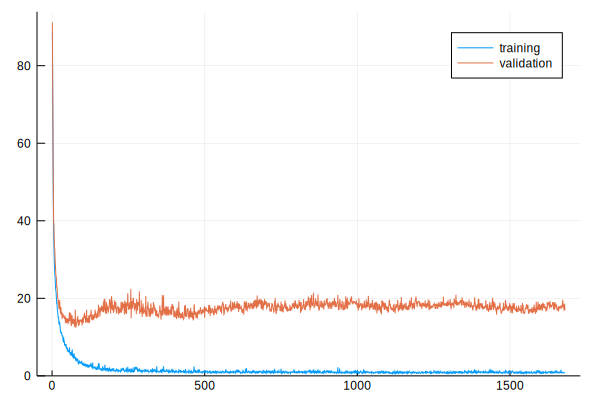

455.325059 seconds (1.33 G allocations: 155.463 GiB, 12.72% gc time)


Progress:  28%|███████████                              |  ETA: 1 days, 8:44:54

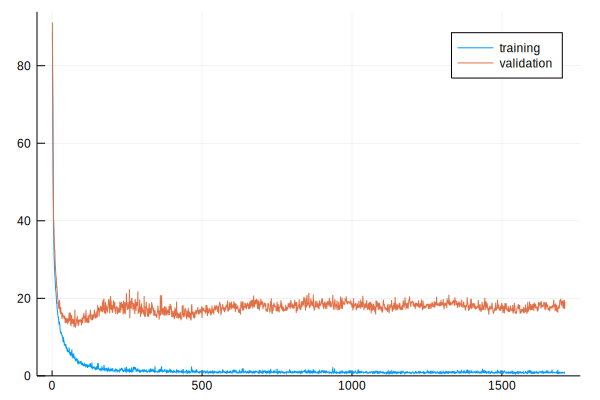

459.607008 seconds (1.33 G allocations: 155.983 GiB, 12.90% gc time)


Progress:  28%|████████████                             |  ETA: 1 days, 8:29:56

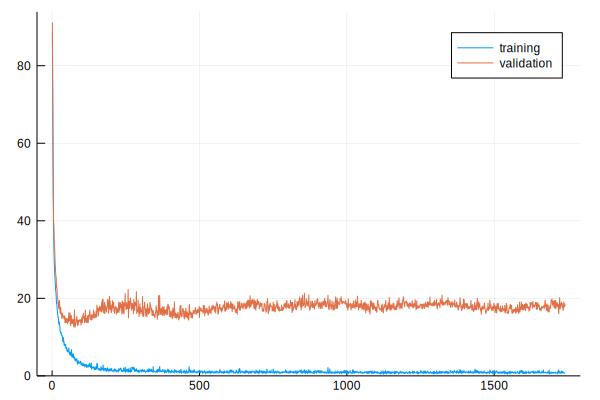

459.377969 seconds (1.34 G allocations: 156.591 GiB, 12.59% gc time)


Progress:  29%|████████████                             |  ETA: 1 days, 8:16:36

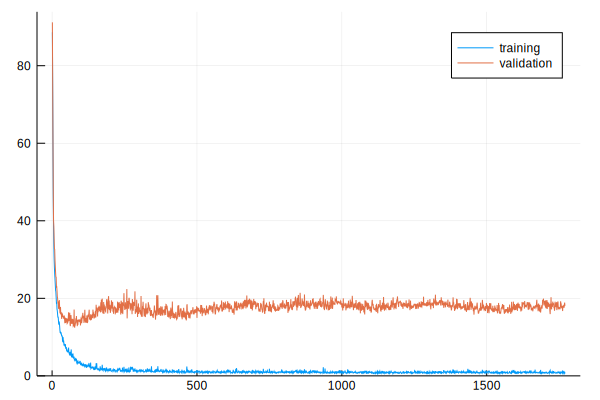

457.564073 seconds (1.34 G allocations: 156.790 GiB, 12.67% gc time)


Progress:  30%|████████████                             |  ETA: 1 days, 7:55:51

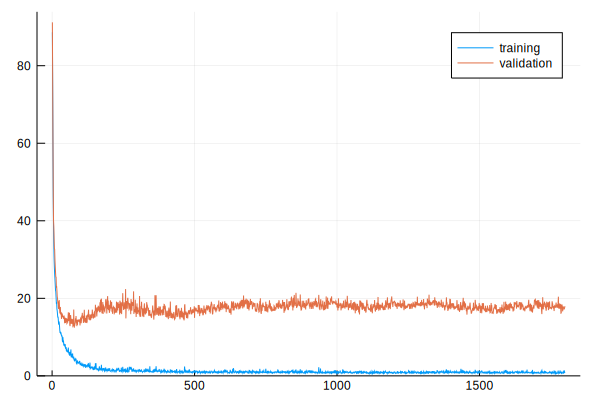

461.963641 seconds (1.35 G allocations: 157.831 GiB, 12.75% gc time)


Progress:  30%|████████████                             |  ETA: 1 days, 7:59:35

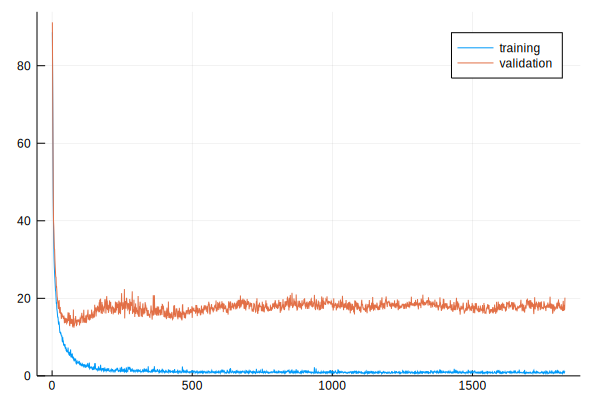

461.857774 seconds (1.35 G allocations: 158.024 GiB, 12.57% gc time)


Progress:  30%|█████████████                            |  ETA: 1 days, 7:42:58

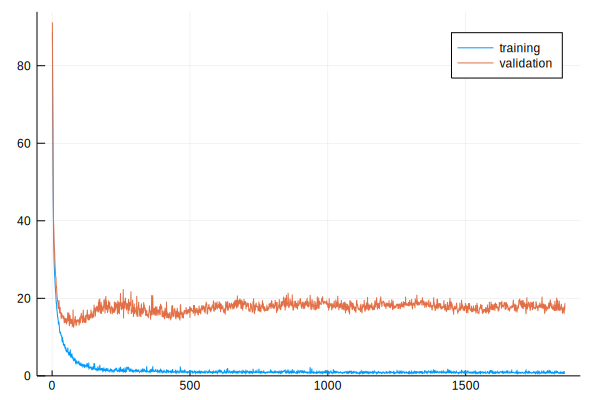

468.059434 seconds (1.35 G allocations: 158.326 GiB, 12.76% gc time)


Progress:  31%|█████████████                            |  ETA: 1 days, 7:29:22

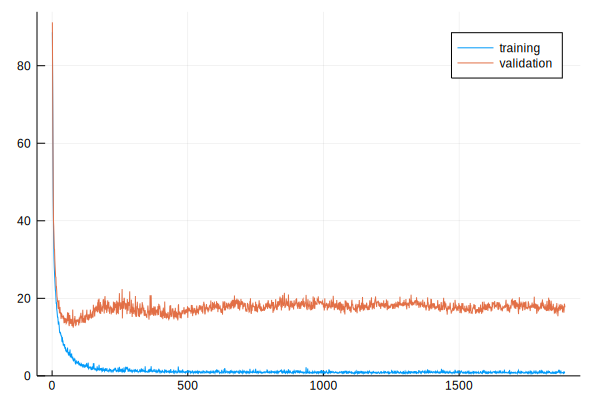

463.805193 seconds (1.35 G allocations: 158.840 GiB, 12.70% gc time)


Progress:  32%|█████████████                            |  ETA: 1 days, 7:14:22

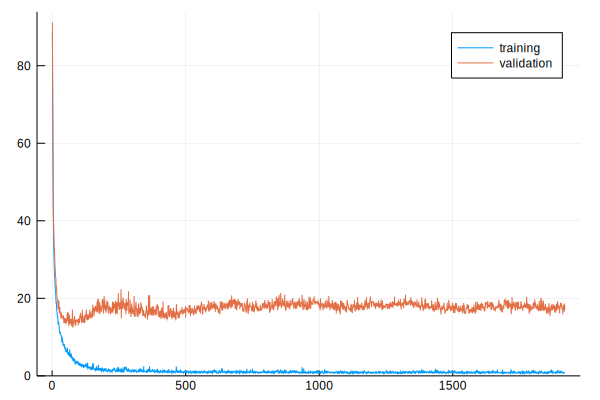

465.695739 seconds (1.36 G allocations: 159.355 GiB, 12.67% gc time)


Progress:  32%|█████████████                            |  ETA: 1 days, 6:59:07

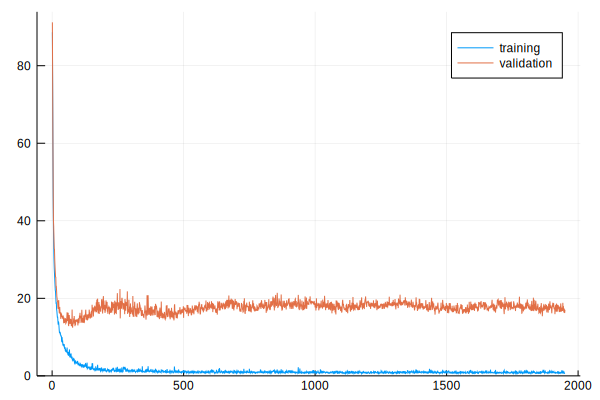

466.039986 seconds (1.36 G allocations: 159.622 GiB, 12.88% gc time)


Progress:  32%|█████████████                            |  ETA: 1 days, 6:44:36

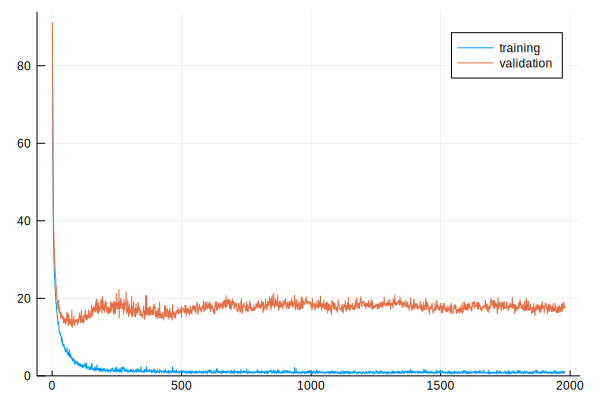

470.413302 seconds (1.37 G allocations: 160.187 GiB, 12.82% gc time)


Progress:  33%|██████████████                           |  ETA: 1 days, 6:33:36

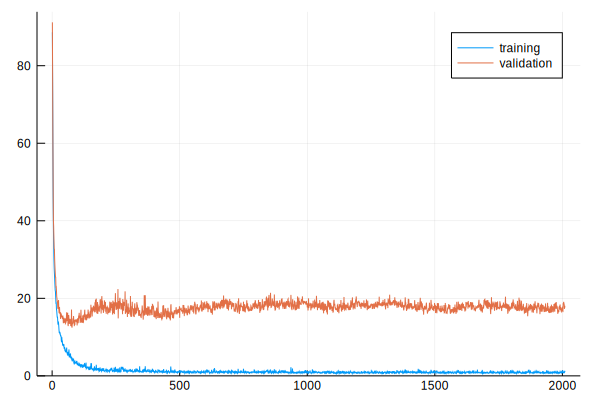

470.955755 seconds (1.37 G allocations: 160.694 GiB, 12.57% gc time)


Progress:  34%|██████████████                           |  ETA: 1 days, 6:23:34

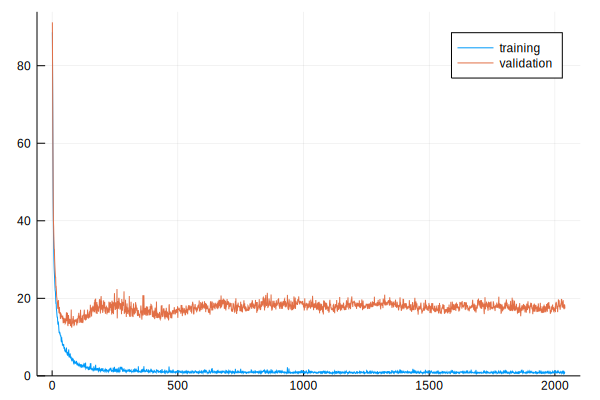

470.621878 seconds (1.37 G allocations: 160.852 GiB, 12.80% gc time)


Progress:  34%|██████████████                           |  ETA: 1 days, 6:01:43

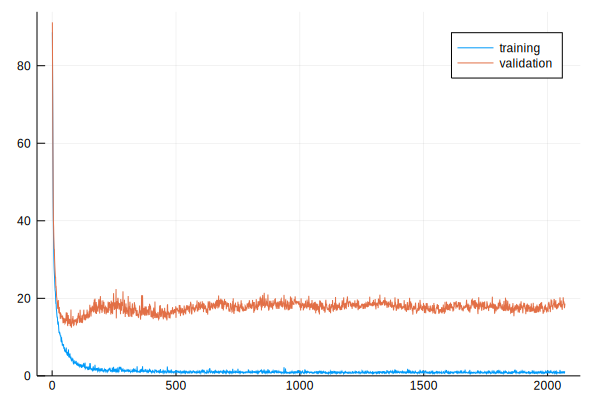

473.939020 seconds (1.38 G allocations: 161.492 GiB, 12.79% gc time)


Progress:  34%|██████████████                           |  ETA: 1 days, 5:50:17

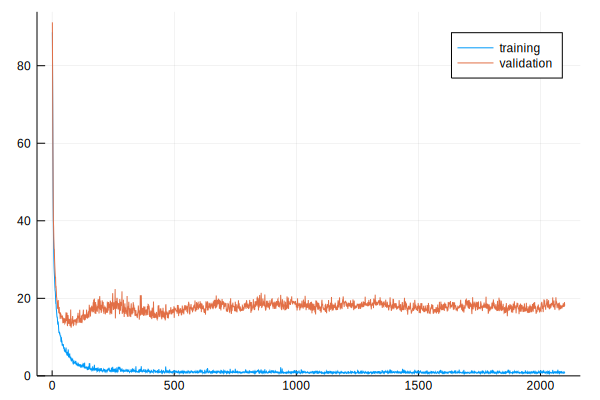

475.608463 seconds (1.39 G allocations: 162.400 GiB, 12.77% gc time)


Progress:  35%|██████████████                           |  ETA: 1 days, 5:42:43

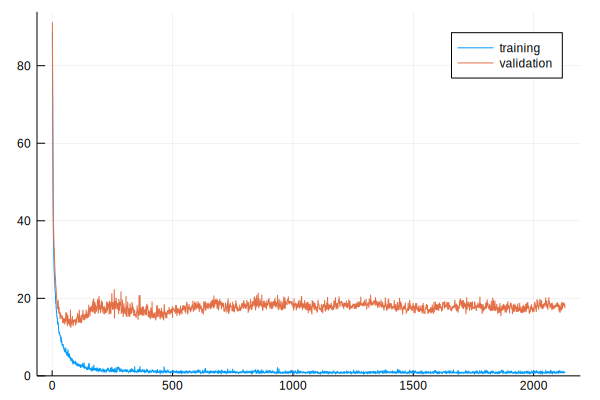

477.217705 seconds (1.39 G allocations: 162.908 GiB, 12.61% gc time)


Progress:  36%|███████████████                          |  ETA: 1 days, 5:32:27

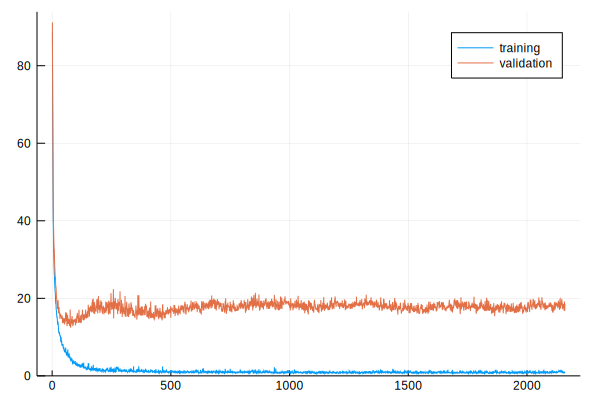

477.818916 seconds (1.39 G allocations: 163.315 GiB, 12.66% gc time)


Progress:  36%|███████████████                          |  ETA: 1 days, 5:18:48

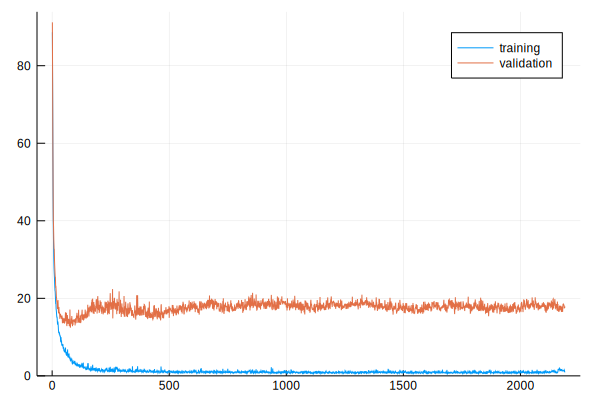

482.160870 seconds (1.40 G allocations: 164.036 GiB, 12.87% gc time)


Progress:  36%|███████████████                          |  ETA: 1 days, 5:12:16

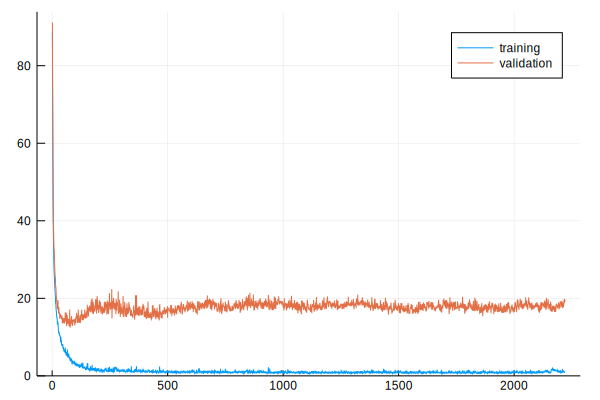

484.131664 seconds (1.40 G allocations: 164.526 GiB, 12.88% gc time)


Progress:  37%|███████████████                          |  ETA: 1 days, 4:57:33

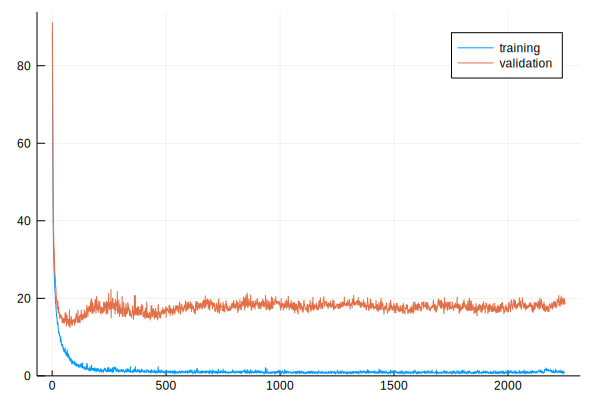

487.736604 seconds (1.41 G allocations: 165.067 GiB, 12.84% gc time)


Progress:  38%|███████████████                          |  ETA: 1 days, 4:44:47

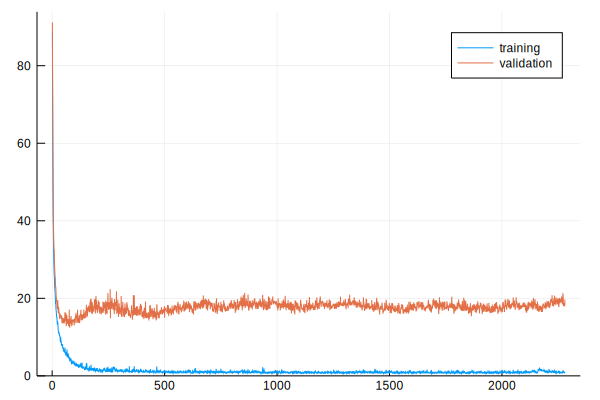

487.261506 seconds (1.42 G allocations: 165.994 GiB, 12.62% gc time)


Progress:  38%|████████████████                         |  ETA: 1 days, 4:37:51

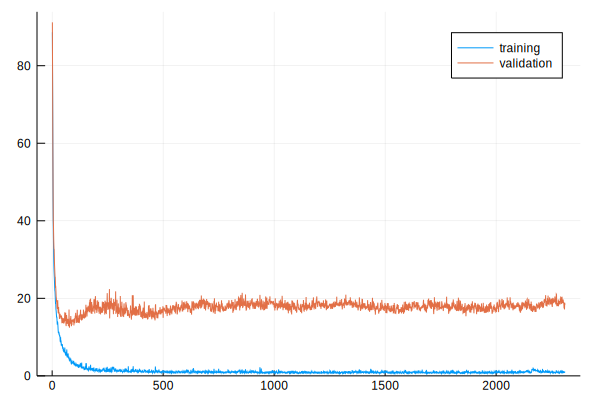

489.701525 seconds (1.42 G allocations: 166.501 GiB, 12.89% gc time)


Progress:  38%|████████████████                         |  ETA: 1 days, 4:24:02

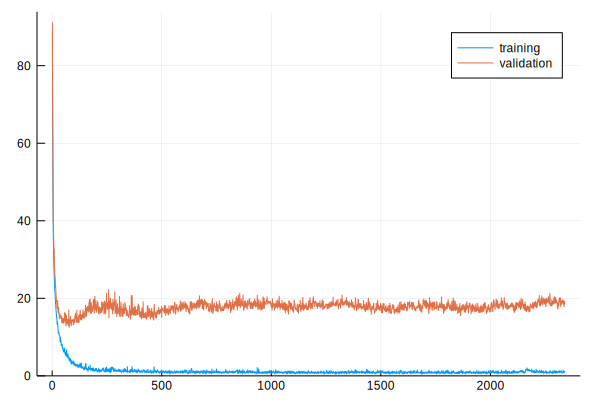

489.781185 seconds (1.43 G allocations: 167.230 GiB, 12.75% gc time)


Progress:  39%|████████████████                         |  ETA: 1 days, 4:17:26

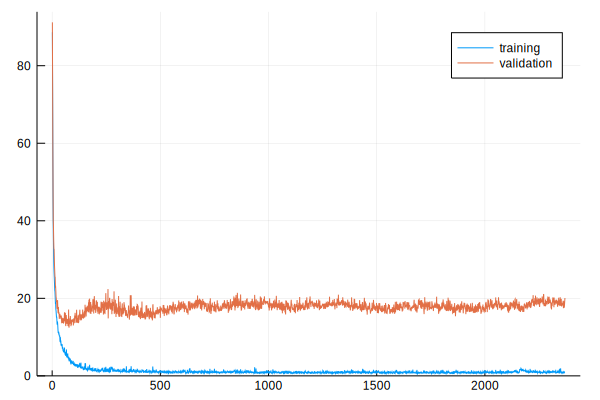

490.645828 seconds (1.43 G allocations: 167.594 GiB, 12.62% gc time)


Progress:  40%|████████████████                         |  ETA: 1 days, 4:00:37

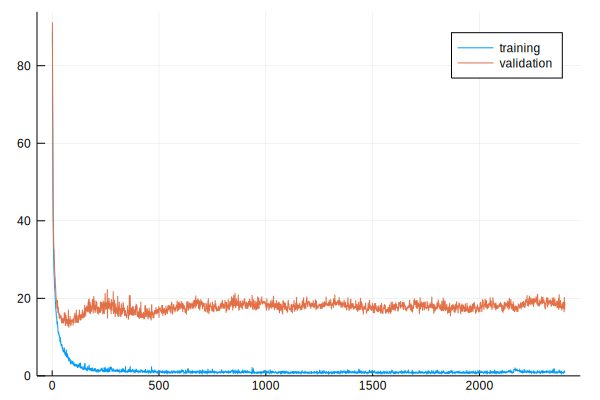

494.016556 seconds (1.43 G allocations: 167.852 GiB, 12.71% gc time)


Progress:  40%|████████████████                         |  ETA: 1 days, 3:46:24

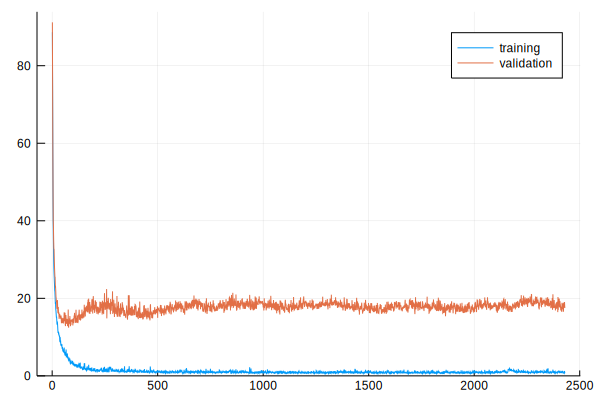

491.050598 seconds (1.43 G allocations: 167.983 GiB, 12.59% gc time)


Progress:  40%|█████████████████                        |  ETA: 1 days, 3:26:20

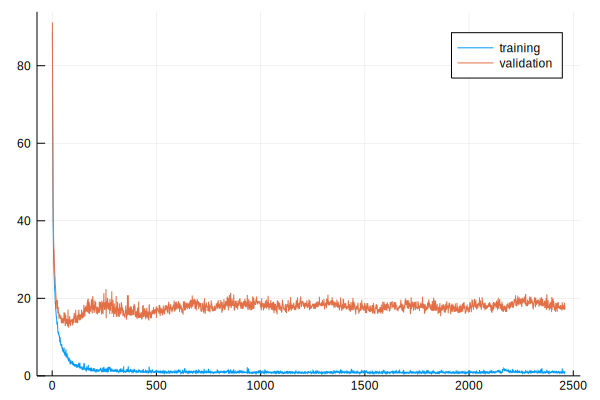

497.236559 seconds (1.44 G allocations: 168.927 GiB, 12.84% gc time)


Progress:  41%|█████████████████                        |  ETA: 1 days, 3:19:40

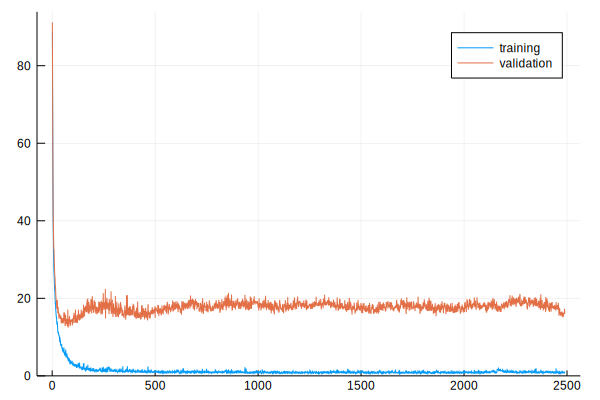

498.229671 seconds (1.45 G allocations: 169.429 GiB, 12.77% gc time)


Progress:  42%|█████████████████                        |  ETA: 1 days, 3:05:25

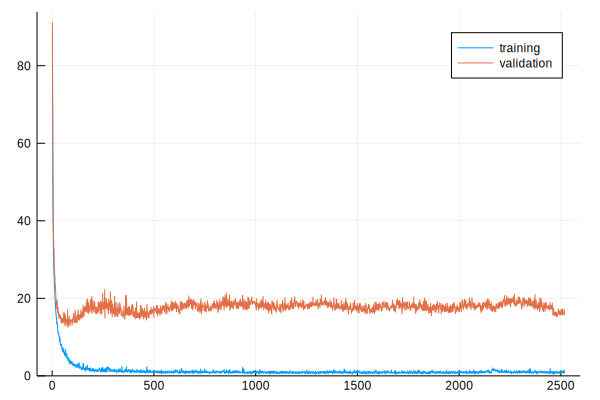

498.622632 seconds (1.45 G allocations: 169.973 GiB, 12.71% gc time)


Progress:  42%|█████████████████                        |  ETA: 1 days, 2:52:38

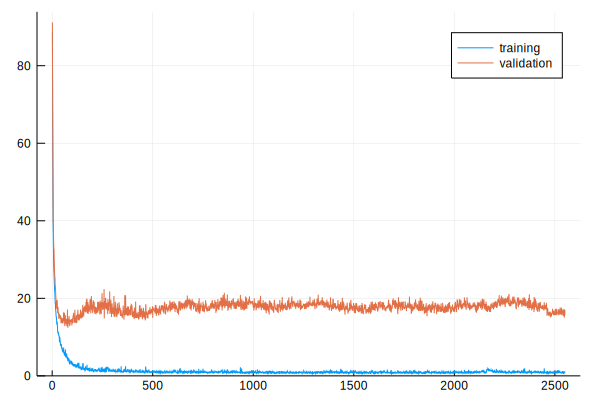

504.077836 seconds (1.46 G allocations: 171.022 GiB, 12.72% gc time)


Progress:  42%|█████████████████                        |  ETA: 1 days, 2:49:00

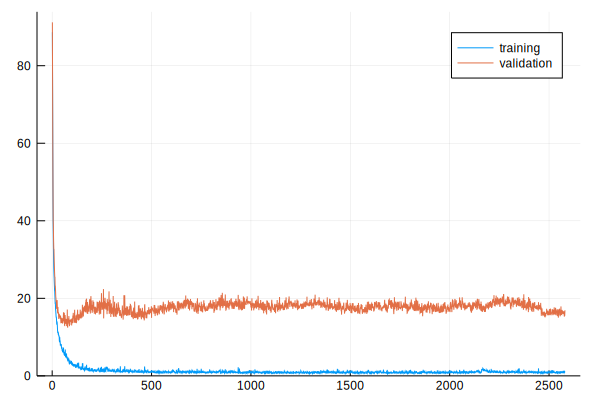

506.368496 seconds (1.46 G allocations: 171.594 GiB, 12.79% gc time)


Progress:  43%|██████████████████                       |  ETA: 1 days, 2:35:54

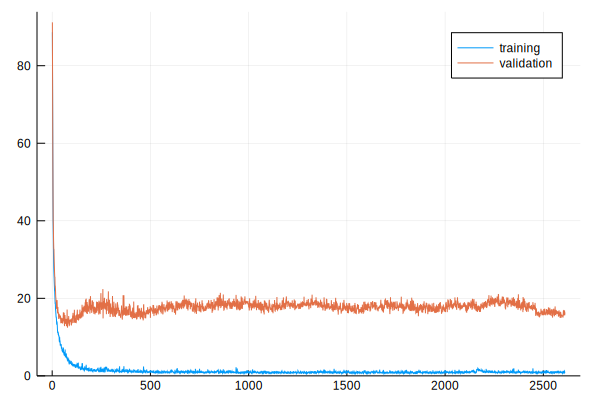

518.309566 seconds (1.47 G allocations: 172.322 GiB, 12.69% gc time)


Progress:  44%|██████████████████                       |  ETA: 1 days, 2:25:03

captured: InterruptException()


Unexpected end of input
 ...when parsing byte with value '0'
Stacktrace:
 [1] _error(

LoadError: [91mMethodError: no method matching LearningMPC.MPCResults{Float64}(::Void, ::Void, ::Array{Float64,1}, ::LearningMPC.MIPResults)[39m

::String, ::JSON.Parser.StreamingParserState{TCPSocket}) at /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/JSON/src/Parser.jl:148
 [2] byteat(::JSON.Parser.StreamingParserState{TCPSocket}) at /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/JSON/src/Parser.jl:58
 [3] chomp_space! at /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/JSON/src/Parser.jl:115 [inlined]
 [4] parse_value(::JSON.Parser.ParserContext{Dict{String,Any},Int64}, ::JSON.Parser.StreamingParserState{TCPSocket}) at /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/JSON/src/Parser.jl:158
 [5] #parse#2(::Type{Dict{String,Any}}, ::Type{Int64}, ::Function, ::TCPSocket) at /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/JSON/src/Parser.jl:406
 [6] macro expansion at /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Lazy/src/macros.jl:241 [inlined]
 [7] macro expansion at /home/rdeits/locomotion/explorations/learning-mpc-2/p

In [15]:
library_file = "library.jld2"

if isfile(library_file)
    all_training_data, all_validation_data = jldopen(library_file) do file
        file["training"], file["testing"]
    end
else
    all_training_data = Vector{Tuple{eltype(sample_sink.samples)}}()
    all_validation_data = Vector{Tuple{eltype(sample_sink.samples)}}()
end;

datasets = Vector{LearningMPC.Dataset{Float64}}()
losses = Vector{Tuple{Float64, Float64}}()

N_iter = 200
σv = 2.0

@showprogress for i in 1:N_iter
    dataset = LearningMPC.Dataset(lqrsol)
    for i in 1:2
        collect_into!(dataset.training_data, σv)
    end
    collect_into!(dataset.validation_data, σv)
    
    filter!(dataset.training_data) do sample
        all(isfinite, sample.input)
    end
    filter!(dataset.validation_data) do sample
        all(isfinite, sample.input)
    end
    
    append!(all_training_data, tuple.(dataset.training_data))
    append!(all_validation_data, tuple.(dataset.validation_data))

    @time for i in 1:30
        Flux.train!(loss, shuffleobs(all_training_data), optimizer)
        push!(losses, 
            (mean(xy -> Flux.Tracker.data(loss(xy...)), 
                  all_training_data),
             mean(xy -> Flux.Tracker.data(loss(xy...)), 
                  all_validation_data)))
    end
    push!(datasets, dataset)
    
    jldopen("boxatlas-regularized-2.jld2", "w") do file
        file["datasets"] = datasets
        file["net"] = net
        file["lqrsol"] = lqrsol
        file["mpc_params"] = Dict(
            "Δt" => params.Δt, 
            "horizon" => params.horizon,
        )
        file["losses"] = losses
    end
    
    jldopen(library_file, "w") do file
        file["training"] = all_training_data
        file["testing"] = all_validation_data
    end
    
    plt = plot(first.(losses), label="training")
    plot!(plt, last.(losses), label="validation")
    ylims!(plt, (0, ylims(plt)[2]))
    display(plt)
end